<a href="https://colab.research.google.com/github/zekaouinoureddine/BM-ASS/blob/master/notebooks/BM_ASS_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
**<h1 align="center"> Abstractive Text Summarization </h1>**

---

In [1]:
!pip install datasets --quiet
!pip install transformers --quiet
!pip install sentencepiece --quiet

In [2]:
!pip install rouge_score --quiet

### Import Libs

In [3]:
import os
import textwrap

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from datasets import load_dataset, load_metric
from transformers import T5Tokenizer, AdamW, T5ForConditionalGeneration

from tqdm import tqdm
from termcolor import colored
from collections import defaultdict
from IPython.display import display, HTML

import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prasa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Utils

In [4]:
def get_cnn_daily_mail_dataset():
  dataset = load_dataset("cnn_dailymail", '3.0.0')
  data = pd.DataFrame({
      "article": dataset["train"]["article"],
      "highlights": dataset["train"]["highlights"],
      })
  return data


def plot_tokens_count(article, highlights):
  arti_token_lens = []
  high_token_lens = []

  for article, highlights in zip(article, highlights):
    arti_token_lens.append(len(article.split()))
    high_token_lens.append(len(highlights.split()))

  sns.set(style='darkgrid')
  sns.set(font_scale=1.5)

  plt.subplots(figsize=(16, 6))

  plt.subplot(1, 2, 1)
  plt.hist(arti_token_lens, color='red', bins=50, alpha=0.5)
  plt.title('Article Tokens Count')
  plt.xlabel('Tokens Count')
  plt.ylabel('Frequency')

  plt.subplot(1, 2, 2)
  plt.hist(high_token_lens, color='red', bins=50, alpha=0.5)
  plt.title('Highlights Tokens Count')
  plt.xlabel('Tokens Count')
  plt.ylabel('Frequency')

  plt.tight_layout(4)

  plt.show();

  
def get_metrics(predictions, labels, metric:str):
  # Rouge expects a newline after each sentence
  decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in predictions]
  decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in labels]
  
  metric = load_metric(metric)
  result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
  
  # Generate few results
  result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
  
  # Add mean generated length
  prediction_lens = [np.count_nonzero(pred != Config.TOKENIZER.pad_token_id) for pred in predictions]
  result["GenLen"] = np.mean(prediction_lens)
  metrics =  {k: round(v, 4) for k, v in result.items()}
  results_df = pd.DataFrame(metrics, index=["Results"])
  results_df.columns = results_df.columns.str.capitalize()
  return results_df

In [5]:
data_ = get_cnn_daily_mail_dataset()
display(HTML(data_.head(2).to_html()))

,article,highlights
0,"LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in ""Harry Potter and the Order of the Phoenix"" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. ""I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar,"" he told an Australian interviewer earlier this month. ""I don't think I'll be particularly extravagant. ""The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs."" At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film ""Hostel: Part II,"" currently six places below his number one movie on the UK box office chart. Details of how he'll mark his landmark birthday are under wraps. His agent and publicist had no comment on his plans. ""I'll definitely have some sort of party,"" he said in an interview. ""Hopefully none of you will be reading about it."" Radcliffe's earnings from the first five Potter films have been held in a trust fund which he has not been able to touch. Despite his growing fame and riches, the actor says he is keeping his feet firmly on the ground. ""People are always looking to say 'kid star goes off the rails,'"" he told reporters last month. ""But I try very hard not to go that way because it would be too easy for them."" His latest outing as the boy wizard in ""Harry Potter and the Order of the Phoenix"" is breaking records on both sides of the Atlantic and he will reprise the role in the last two films. Watch I-Reporter give her review of Potter's latest » . There is life beyond Potter, however. The Londoner has filmed a TV movie called ""My Boy Jack,"" about author Rudyard Kipling and his son, due for release later this year. He will also appear in ""December Boys,"" an Australian film about four boys who escape an orphanage. Earlier this year, he made his stage debut playing a tortured teenager in Peter Shaffer's ""Equus."" Meanwhile, he is braced for even closer media scrutiny now that he's legally an adult: ""I just think I'm going to be more sort of fair game,"" he told Reuters. E-mail to a friend . Copyright 2007 Reuters. All rights reserved.This material may not be published, broadcast, rewritten, or redistributed.",Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .\nYoung actor says he has no plans to fritter his cash away .\nRadcliffe's earnings from first five Potter films have been held in trust fund .
1,"Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the ""forgotten floor,"" where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the ""forgotten floor."" Here, inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually ""avoidable felonies."" He says the arrests often result from confrontations with police. Mentally ill people often won't do what they're told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less likely to follow directions, according to Leifman. So, they end up on the ninth floor severely mentally disturbed, but not getting any real help because they're in jail. We toured the jail with Leifman. He is well

TypeError: tight_layout() takes 0 positional arguments but 1 was given

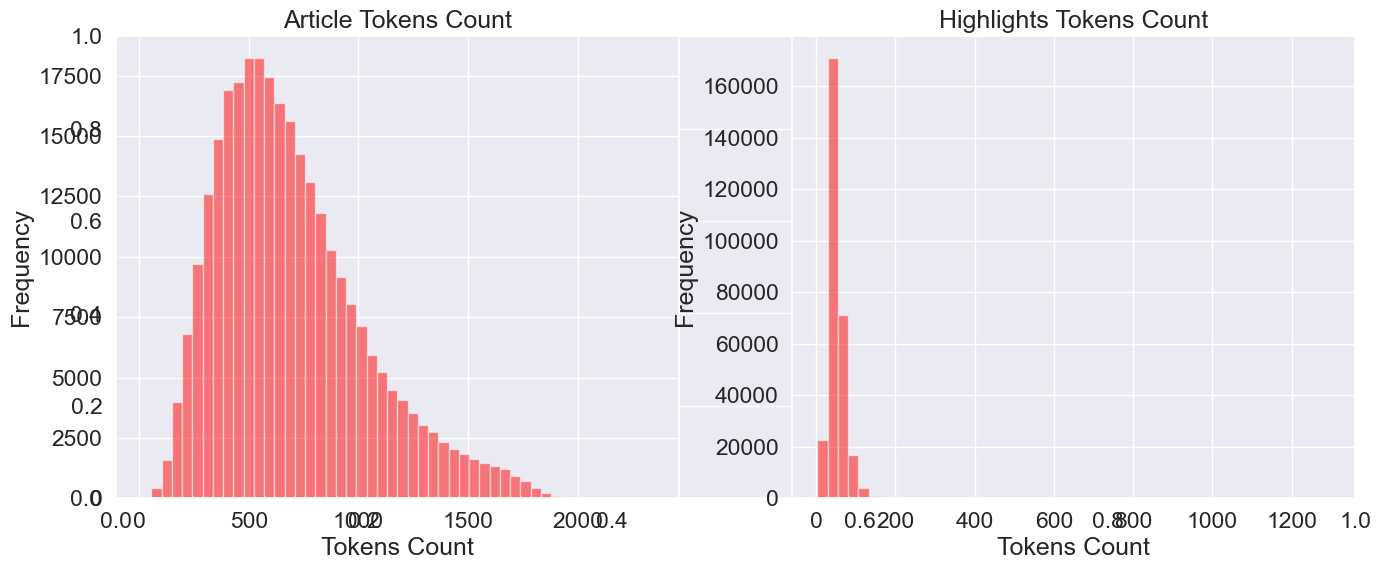

In [9]:
plot_tokens_count(data_.article, data_.highlights)

In [10]:
df = data_[:500]

### Config

In [ ]:
class Config:
  EPOCHS = 25
  MAX_LEN = 512
  HIG_MAX_LEN = 64
  ART_MAX_LEN = 512
  LEARNING_RATE = 3e-5
  TRAIN_BATCH_SIZE = 10
  VALID_BATCH_SIZE = 10
  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  CHECKPOINT = "t5-base"
  MODEL_PATH = "t5ass.bin"

  TOKENIZER = T5Tokenizer.from_pretrained(CHECKPOINT)
  MODEL = T5ForConditionalGeneration.from_pretrained(CHECKPOINT, return_dict=True)

### Dataset

In [12]:
class CNNDailyMailDataset(Dataset):
  def __init__(self, article, highlights):
    self.article = article
    self.highlights = highlights

    self.tokenizer = Config.TOKENIZER
    self.art_max_len = Config.ART_MAX_LEN
    self.hig_max_len = Config.ART_MAX_LEN

  def __len__(self):
    return len(self.highlights)

  def __getitem__(self, index):
    article = str(self.article[index])
    highlights = str(self.highlights[index])

    article = " ".join(article.split())
    highlights = " ".join(highlights.split())

    article_inputs = self.tokenizer.batch_encode_plus(
        [article],
        max_length=self.art_max_len,
        pad_to_max_length=True,
        truncation=True,
        padding="max_length"
        )
    highlights_inputs = self.tokenizer.batch_encode_plus(
        [highlights],
        max_length=self.hig_max_len,
        pad_to_max_length=True,
        truncation=True,
        padding="max_length"
        )
    
    article_input_ids = article_inputs["input_ids"]
    article_attention_mask = article_inputs["attention_mask"]
    
    highlights_input_ids = highlights_inputs["input_ids"]
    highlights_attention_mask = highlights_inputs["attention_mask"]
    
    labels = [label if label != 0 else -100 for label in highlights_input_ids]

    return {
        "article_ids": torch.tensor(highlights_input_ids, dtype=torch.long).squeeze(),
        "article_mask": torch.tensor(article_attention_mask, dtype=torch.long).squeeze(),
        "highlights_ids": torch.tensor(highlights_input_ids, dtype=torch.long).squeeze(),
        "highlights_mask": torch.tensor(highlights_attention_mask, dtype=torch.long).squeeze(),
        "labels": torch.tensor(labels, dtype=torch.long).squeeze(),
    }

### Model

In [13]:
class CNNDailyMailModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = Config.MODEL

  def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
    output = self.model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_attention_mask=decoder_attention_mask,
        labels=labels,
    )
    return output.loss, output.logits

### Engine

In [14]:
def train_fn(train_dataloader, model, optimizer, device):
  model.train()
  final_loss = 0
  fin_labels = []
  fin_outputs = []
  for data in tqdm(train_dataloader, total=len(train_dataloader)):
    art_ids = data["article_ids"].to(device)
    art_mask = data["article_mask"].to(device)
    
    labels = data["labels"].to(device)
    labels_attention_mask = data["highlights_mask"].to(device)

    loss, logits = model(
        input_ids=art_ids,
        attention_mask=art_mask,
        decoder_attention_mask=labels_attention_mask,
        labels =  labels
        )
    final_loss += loss.item()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return final_loss/len(train_dataloader)


def eval_fn(valid_dataloader, model, device):
  model.eval()
  final_loss = 0
  decoded_labels = []
  decoded_preds = []
  with torch.no_grad():
    for data in tqdm(valid_dataloader, total=len(valid_dataloader)):
      art_ids = data["article_ids"].to(device)
      art_mask = data["article_mask"].to(device)
      
      labels = data["labels"].to(device)
      labels_attention_mask = data["highlights_mask"].to(device)

      loss, logits = model(
          input_ids=art_ids,
          attention_mask=art_mask,
          decoder_attention_mask=labels_attention_mask,
          labels =  labels
          )
      final_loss += loss.item()
      
      generated_ids = model.model.generate(
          input_ids = art_ids,
          attention_mask = art_mask,
          max_length=150,
          num_beams=2,
          repetition_penalty=2.5,
          length_penalty=1.0,
          early_stopping=True
          )
      
      # Replace -100 in the labels as we can't decode them.
      labels = torch.where(labels != -100, labels, Config.TOKENIZER.pad_token_id)
      
      decoded_preds.extend([Config.TOKENIZER.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids])
      decoded_labels.extend([Config.TOKENIZER.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in labels])

  return decoded_preds, decoded_labels, final_loss/len(valid_dataloader)

### Train

In [15]:
train_df, test_df = train_test_split(df, test_size=0.2)

train_dataset = CNNDailyMailDataset(
    article=train_df["article"].values,
    highlights=train_df["highlights"].values,
)

valid_dataset = CNNDailyMailDataset(
    article=test_df["article"].values,
    highlights=test_df["highlights"].values,
)

In [16]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=Config.TRAIN_BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=0
                              )

valid_dataloader = DataLoader(valid_dataset, 
                              batch_size=Config.VALID_BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=0)

In [17]:
model = CNNDailyMailModel()
model = model.to(Config.DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)

In [10]:
# history = defaultdict(list)
best_loss = np.inf

for epoch in range(1, Config.EPOCHS+1):
  train_loss = train_fn(train_dataloader, model, optimizer, Config.DEVICE)
  decoded_preds, decoded_labels, valid_loss = eval_fn(valid_dataloader, model, Config.DEVICE)
  
  print(f"Train Loss: {train_loss}, Valid Loss: {valid_loss}\n")
  
  history['Train Loss'].append(train_loss)
  history['Valid Loss'].append(valid_loss)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), Config.MODEL_PATH)

    
    best_loss = valid_loss

NameError: name 'np' is not defined

### Evaluation

In [7]:
def loss_curve(train_loss, valid_loss):
  sns.set(style='darkgrid')
  sns.set(font_scale=1)
  plt.rcParams["figure.figsize"] = (12, 4)
  plt.plot(train_loss, 'b-o', label="Training Loss")
  plt.plot(valid_loss, 'r-o', label="Validation Loss")
  plt.title("Learning Curve")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show();

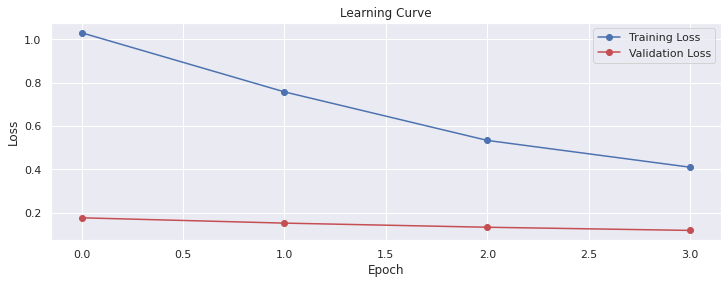

In [ ]:
loss_curve(
    history['Train Loss'], 
    history['Valid Loss']
    ) 

In [8]:
metrics = get_metrics(decoded_preds, decoded_labels, metric="rouge")
metrics

NameError: name 'get_metrics' is not defined

### Inference

In [ ]:
class Process:
  def __init__(self, article_text):
    self.article_text = article_text
    self.art_max_len = Config.ART_MAX_LEN
    self.tokenizer = Config.TOKENIZER


  def pre_process(self):
    article_text = str(self.article_text)
    article_text = " ".join(article_text.split())

    inputs = self.tokenizer.batch_encode_plus(
        [article_text],
        max_length=self.art_max_len,
        pad_to_max_length=True,
        truncation=True,
        padding="max_length"
        )
    
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    return (
        torch.tensor(input_ids, dtype=torch.long),
        torch.tensor(attention_mask, dtype=torch.long)
        )

  def post_process(self, generated_ids):
    preds = [
        self.tokenizer.decode(generated_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        for generated_id in generated_ids
        ]
    return " ".join(preds)

In [ ]:
model = CNNDailyMailModel()
model.to(Config.DEVICE)
model.load_state_dict(
    torch.load(
        Config.MODEL_PATH,
        map_location=torch.device(Config.DEVICE)
        )
    )


def get_important_paragh(article_text):
  data = Process(article_text)
  input_ids, attention_mask = data.pre_process()
  input_ids = input_ids.to(Config.DEVICE)
  attention_mask = attention_mask.to(Config.DEVICE)

  with torch.no_grad():
    generated_ids = model.model.generate(
        input_ids = input_ids,
        attention_mask = attention_mask,
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

  predicted_high = data.post_process(generated_ids)
  return predicted_high

In [ ]:
article_text = """
          The tower is 324 metres (1,063 ft) tall, about the same height as an 
          81-storey building, and the tallest structure in Paris. Its base is 
          square, measuring 125 metres (410 ft) on each side. During its construction,
          the Eiffel Tower surpassed the Washington Monument to become the tallest 
          man-made structure in the world, a title it held for 41 years until the Chrysler
          Building in New York City was finished in 1930. It was the first structure to 
          reach a height of 300 metres. Due to the addition of a broadcasting aerial at 
          the top of the tower in 1957, it is now taller than the Chrysler Building by 5.2 
          metres (17 ft). Excluding transmitters, the Eiffel Tower is the second tallest 
          free-standing structure in France after the Millau Viaduct.
       """

In [ ]:
important_paragh = get_important_paragh(article_text)
important_paragh

'the tallest man-made structure in the world. It is 324 metres (1,063 ft) tall and measures 125 metres (410 ft) on each side.'

> ### Using the [URL](https://www.theguardian.com/world/2023/jan/19/three-children-among-six-killed-during-indian-kite-flying-festival)

In [ ]:
import requests
from bs4 import BeautifulSoup

def get_url_paragraphs(url):
  response = requests.get(url)
  soup = BeautifulSoup(response.text, 'html.parser')
  # Find all <p> tags and extract their text
  paragraphs = [p.get_text() for p in soup.find_all('p')]
  return " ".join(paragraphs)

In [ ]:
url = 'https://www.theguardian.com/world/2023/jan/19/three-children-among-six-killed-during-indian-kite-flying-festival'

paragraphs = get_url_paragraphs(url)
paragraphs_text

'Victims reportedly bled to death when glass-coated strings were entangled around their necks Six people, including three children, have died after their throats were cut by glass-coated kite strings during an annual kite-flying festival in India. Hundreds flocked to terraces and rooftops to unfurl their kites towards the sky at the Uttarayan festival in the western Indian state of Gujarat over the weekend. The victims reportedly bled to death when the razor-sharp kite strings became entangled around their necks, officials told the Press Trust of India (PTI). At least another 176 people were injured due to cuts and falls. Some participants are known to coat their kite strings with powdered glass in order to slice their opponent’s cords while in the air. Although the practice has been banned since 2016, critics say it is rarely enforced. A two-year-old girl reportedly died after a kite string struck her neck while riding on a scooter with her father, PTI cited an official from Bortalav 

In [ ]:
len(paragraphs_text)

3354

In [ ]:
important_paragh = get_important_paragh(paragraphs_text)
important_paragh

'Kirti died during treatment at a hospital on Sunday. Another girl, aged three, was walking home with her mother in Visnagar town on Saturday when a string cut her neck. At least another 176 people were injured due to cuts and falls.'

In [ ]:
len(important_paragh)

232

In [1]:
import pickle

In [3]:
!pip install tensorflow

     ---------------------------------------- 0.0/46.1 kB ? eta -:--:--
     ---------------------------------------- 46.1/46.1 kB 2.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/377.1 MB ? eta -:--:--
   ---------------------------------------- 0.4/377.1 MB 12.8 MB/s eta 0:00:30
   ---------------------------------------- 1.2/377.1 MB 15.1 MB/s eta 0:00:25
   ---------------------------------------- 2.1/377.1 MB 17.0 MB/s eta 0:00:23
   ---------------------------------------- 3.0/377.1 MB 17.5 MB/s eta 0:00:22
   ---------------------------------------- 4.0/377.1 MB 18.1 MB/s eta 0:00:21
   ---------------------------------------- 4.3/377.1 MB 16.0 MB/s eta 0:00:24
    --------------------------------------- 5.2/377.1 MB 17.5 MB/s eta 0:00:22
    --------------------------------------- 6.0/377.1 MB 18.2 MB/s eta 0:00:21
    --------------------------------------- 6.0/377.1 MB 18.2 MB/s eta 0:00:21
    --------------------------------------- 6.0/377.1 MB 18.2 MB/s

In [7]:
from tensorflow.keras.models import Model,load_model
pickle.dump(Model, open('D:\sivapython\mainp\pickle_model_saved','wb'))



<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\prasa\AppData\Local\Temp\ipykernel_10476\853811762.py:2: SyntaxWarning: invalid escape sequence '\s'
  pickle.dump(Model, open('D:\sivapython\mainp\pickle_model_saved','wb'))


In [9]:
model_loaded=pickle.load(open('D:\sivapython\mainp\pickle_model_saved','rb'))

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\prasa\AppData\Local\Temp\ipykernel_10476\2223655794.py:1: SyntaxWarning: invalid escape sequence '\s'
  model_loaded=pickle.load(open('D:\sivapython\mainp\pickle_model_saved','rb'))


In [ ]:
import torch


 Define a function to load the model
def load_model(model_class, model_path, device):
    model = model_class()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    print("Model loaded successfully.")
    return model

# Define a function to predict using the loaded model
def predict(model, article_text, device):
    data = Process(article_text)
    input_ids, attention_mask = data.pre_process()
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        generated_ids = model.model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=150,
            num_beams=2,
            repetition_penalty=2.5,
            length_penalty=1.0,
            early_stopping=True
        )

    predicted_high = data.post_process(generated_ids)
    return predicted_high

# Example usage:
# Save the model
 save_model(model, "saved_model.pt")

# Load the model
loaded_model = load_model(CNNDailyMailModel, "saved_model.pt", Config.DEVICE)
